<a href="https://colab.research.google.com/github/Tolulope-Akinmoju/corise-r-for-ds/blob/main/Tolulope_Akinmoju_Explore_100%2B_Years_of_Baby_Names.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> __DUPLICATE THIS COLAB TO START WORKING ON IT. Using File > Save a copy to drive.__


## Exploring 100+ Years of US Baby Names

In this project, we will explore 100+ years of US Baby Names. Although this dataset only has 4 columns, there are so many interesting  questions one could explore. While the possibilities are endless, here are five interesting questions for you to explore.

1. Popular Names: What are the most popular names?
2. Trendy Names: What are trendy names?
3. Popular Letters: What are the most popular letters in names?
4. Popular Letter Combinations: What are the most popular letter combinations?
5. Vowels vs Consonants: Are there naming trends in usage of vowels and consonants?

You need to complete at least the first three questions. The last two questions are optional.

### Import
Let us start by importing the data from `data/names.csv.gz`. You can use the `read_csv` function from the `readr` package to do this.

In [1]:
options(repr.plot.width = 12)
options(repr.plot.height = 8)
options(jupyter.plot_mimetypes = "image/svg+xml") 
ggplot2::theme_set(ggplot2::theme_gray(base_size = 16))

In [3]:
# Load the tidyverse package
library(tidyverse)

# Read the csv file `file_name_names` as data frame `tbl_names`
file_name_names <- "https://github.com/ramnathv/corise-r-for-ds/raw/main/data/names.csv.gz"
tbl_names <- readr::read_csv(
  file = file_name_names, 
  show_col_types = FALSE
)

# Print head of `tbl_names`
print(tbl_names)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.2
✔ tidyr   1.3.0     ✔ stringr 1.4.1
✔ readr   2.1.4     ✔ forcats 1.0.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



# A tibble: 2,052,781 × 4
    year name      sex   nb_births
   <dbl> <chr>     <chr>     <dbl>
 1  1880 Mary      F          7065
 2  1880 Anna      F          2604
 3  1880 Emma      F          2003
 4  1880 Elizabeth F          1939
 5  1880 Minnie    F          1746
 6  1880 Margaret  F          1578
 7  1880 Ida       F          1472
 8  1880 Alice     F          1414
 9  1880 Bertha    F          1320
10  1880 Sarah     F          1288
# ℹ 2,052,771 more rows


### Question 1: [Popular Names] What are the most popular names?

One of the first things we want to do is to understand naming trends. Let us 
start by figuring out the top five most popular male and female names for this 
decade (born 2011 and after, but before 2021). Do you want to make any guesses?  

#### Transform

The first step is always to transform the data into a form that is easy to visualize. If we create a table with `sex`, `name` and `nb_births` for the top 5 names for each `sex`, then we can turn it into a column plot using `ggplot2`. Let us get the five most popular male and female names of the decade starting in 2011.

In [4]:
tbl_names_popular = tbl_names |> 
  # Keep ROWS for year > 2010 and <= 2020
  filter(year > 2010, year <= 2020) |> 
  # Group by sex and name
  group_by(sex, name) |> 
  # Summarize the number of births
  summarize(
    nb_births = sum(nb_births),
    .groups = "drop"
  ) |> 
  # Group by sex 
  group_by(sex) |>  
  # For each sex, keep the top 5 rows by number of births
  slice_max(nb_births, n = 5)

tbl_names_popular

sex,name,nb_births
<chr>,<chr>,<dbl>
F,Emma,193138
F,Olivia,184966
F,Sophia,173341
F,Isabella,159570
F,Ava,153414
M,Noah,184977
M,Liam,182646
M,William,155326
M,Mason,152944


#### Visualize

Let us now visualize this data as a horizontal bar plot of number of births by name faceted by sex.

Here, when thinking about how we might label this table, look back to the statement of the question. Make sure to use this information in a way so that the title, subtitle, and caption provide your reader with concise, descriptive language so that viewers can quickly grasp the plot's purpose and findings.

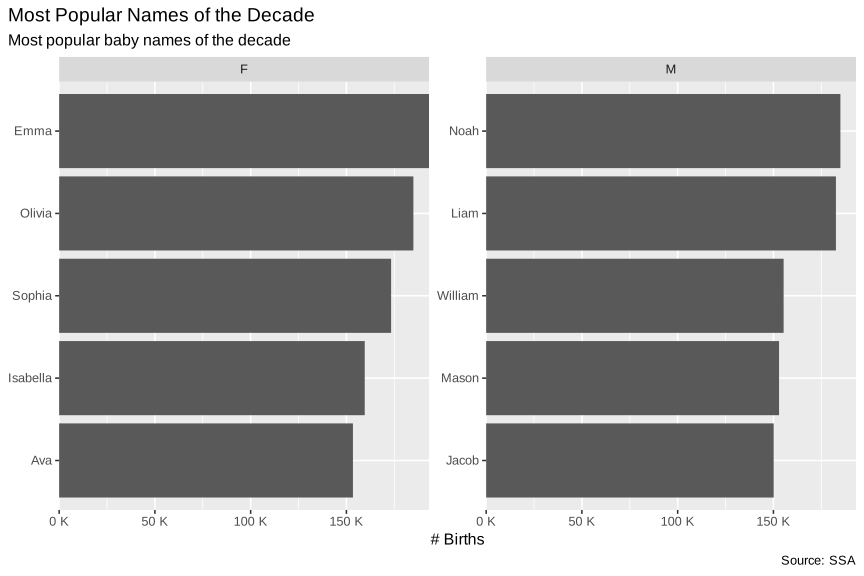

In [6]:
tbl_names_popular |> 
  # Reorder the names by number of births
  mutate(name = fct_reorder(name, nb_births)) |>
  # Initialize a ggplot for name vs. nb_births
  ggplot(aes(x = nb_births, y = name)) +
  # Add a column plot layer
  geom_col() +
  # Facet the plots by sex
  facet_wrap(~ sex, scales = "free_y") +
  # Add labels (title, subtitle, caption, x, y)
  labs(
    title = 'Most Popular Names of the Decade',
    subtitle = 'Most popular baby names of the decade',
    caption = 'Source: SSA',
    x = '# Births',
    y = NULL
  ) +
  # Fix the x-axis scale 
  scale_x_continuous(
    labels = scales::unit_format(scale = 1e-3, unit = "K"),
    expand = c(0, 0),
  ) +
  # Move the plot title to top left
  theme(
    plot.title.position = 'plot'
  )

### Question 2: [Trendy Names] What are trendy names?

Consider the following two names `Elizabeth` and `Deneen`. `Elizabeth` is a 
fairly stable name, while `Deneen` is not, when one looks at trends. An interesting question to ask would be what are the top 5 stable and top 5 
trendiest names. A stable name is one whose numbers across years don't vary drastically, while a trendy name is one whose popularity peaks for a short period 
and then dies down.

There are many ways to capture trendiness. A simple measure would be to look at the maximum number of births for a name, normalized by the sum of 
of births across years. A trendy name would have a high value.

Let us use this idea to figure out the top 10 trendy names in this data set. Let
us use a cutoff of at least a 1000 births across all the years, so we don't pick up low-volume names. Feel free to experiment with this threshold as you see fit.

#### Transform

We need to transform the data into a table that consists of the columns `sex`, `name`, `nb_births_total`, `nb_births_max` and `trendiness`. We compute 
`nb_births_total` as the total number of births across all years, and `nb_births_max` as the maximum number of births for a given name across all years. Finally, we compute trendiness as a ratio of these two numbers. Follow the recipe outlined below to carry out the transformation.

In [9]:
tbl_names_popular_trendy = tbl_names |> 
  # Group by sex and name
  group_by(sex, name) |> 
  # Summarize total number of births and max births in a year
  summarize(
    nb_births_total = sum(nb_births),
    nb_births_max = max(nb_births),
    .groups = "drop"
  ) |> 
  # Filter for names with at least 10000 births
  filter(nb_births_total > 10000) |> 
  # Add a column for trendiness computed as ratio of max to total
  mutate(trendiness =  nb_births_max/ nb_births_total) |> 
  # Group by sex
 group_by(sex) |> 
  # Slice top 5 rows by trendiness for each group
  slice_max(trendiness, n = 5)

head(tbl_names_popular_trendy)

sex,name,nb_births_total,nb_births_max,trendiness
<chr>,<chr>,<dbl>,<dbl>,<dbl>
F,Katina,11284,2745,0.2432648
F,Ashanti,12141,2945,0.2425665
F,Marquita,11010,2543,0.2309718
F,Everleigh,12738,2814,0.2209138
F,Miley,12865,2649,0.2059075
M,Luka,14393,3197,0.2221219



Note: There are always several different approaches to the same transformation. When it comes to learning, there's no one-size-fits-all solution. One way to make your learning stick is by trying to solve a problem in different ways. Even if you don't get to the final answer, you will learn a lot by exploring different approaches.

#### Visualize

Let us write a function that will accept a name as an argument and return a plot with trends in number of births. We can then use this function to plot the trends for different names.

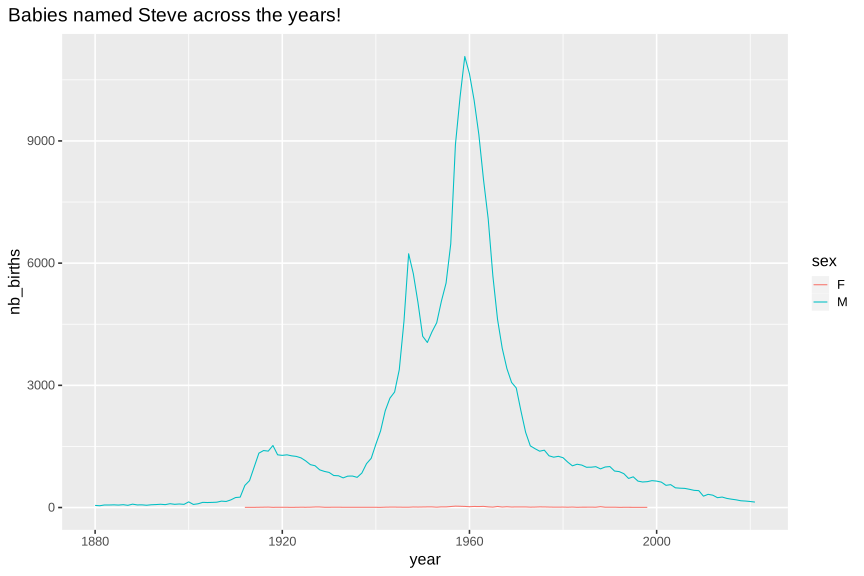

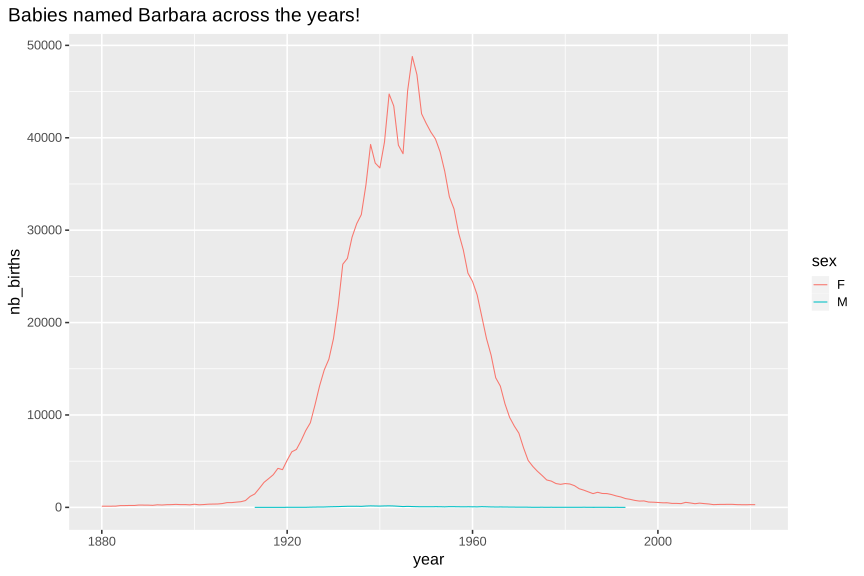

In [10]:
plot_trends_in_name <- function(my_name) {
  tbl_names |> 
    # Filter for name = my_name
    filter(name == my_name) |> 
    # Initialize a ggplot of `nb_births` vs. `year` colored by `sex`
    ggplot(aes(x = year, y = nb_births, color = sex)) +
    # Add a line layer
    geom_line() +
    # Add labels (title, x, y)
    labs(
      title = glue::glue("Babies named {my_name} across the years!"),
      x = 'year',
      y = 'nb_births'
    ) +
    # Update plot theme
    theme(plot.title.position = "plot")
}

plot_trends_in_name("Steve")
plot_trends_in_name("Barbara")

### Question 3: [Popular Letters] What are the most popular letters in names?

Have you ever wondered why some letters seem to be more prevalent in names than others? In this question, you will embark on a journey to uncover the reasons behind the popularity of specific letters in names. This investigation will lead you to interesting insights about how the popularity of letters in names has changed over time and the potential factors that have influenced these trends.

1. How have the first and last letters in names changed over the years by sex?
2. What are the trends in percentage of names with a given first or last letter across years.
3. What are the most popular combinations of first and last letters?

#### Transform

Let us start by transforming the data and adding two columns, one for `first_letter` and one for `last_letter`. You can use the `str_sub()` function from the `stringr` package to do this.

In [11]:
tbl_names = tbl_names |> 
  # Add NEW column first_letter by extracting `first_letter` from name using `str_sub`
  mutate(first_letter = str_sub(name, 1, 1)) |>  
  # Add NEW column last_letter by extracting `last_letter` from name using `str_sub`
  mutate(last_letter = str_sub(name, -1, -1)) |> 
  # UPDATE column `last_letter` to upper case using `str_to_upper`
  mutate(last_letter = str_to_upper(last_letter))

head(tbl_names)

year,name,sex,nb_births,first_letter,last_letter
<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>
1880,Mary,F,7065,M,Y
1880,Anna,F,2604,A,A
1880,Emma,F,2003,E,A
1880,Elizabeth,F,1939,E,H
1880,Minnie,F,1746,M,E
1880,Margaret,F,1578,M,T


Begin by computing the distribution of births across year and sex by first letter of a name.

In [12]:
tbl_names_by_letter = tbl_names |> 
  # Group by year, sex and first_letter
  group_by(year, sex, first_letter) |> 
  # Summarize total number of births, drop the grouping
  summarize(nb_births = sum(nb_births), .groups = "drop") |> 
  # Group by year and sex
  group_by(year, sex) |> 
  # Add NEW column pct_births by dividing nb_births by sum(nb_births)
  mutate(pct_births = nb_births / sum(nb_births))
    
head(tbl_names_by_letter)

year,sex,first_letter,nb_births,pct_births
<dbl>,<chr>,<chr>,<dbl>,<dbl>
1880,F,A,9334,0.10257819
1880,F,B,3876,0.04259622
1880,F,C,5868,0.06448777
1880,F,D,2218,0.02437523
1880,F,E,11444,0.12576653
1880,F,F,2957,0.03249665


#### Visualize

Visualize the distribution of births by first letter for the year 2020, faceted by sex.

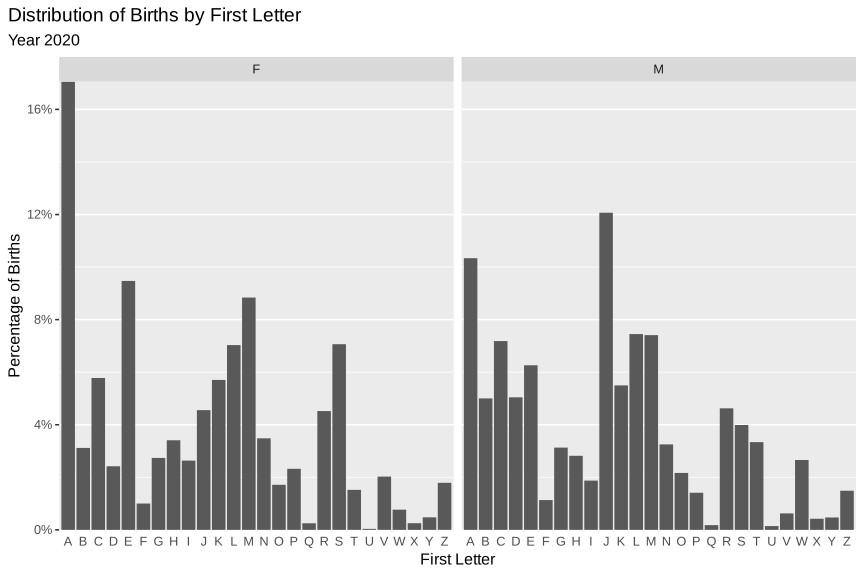

In [16]:
tbl_names_by_letter |> 
  # Filter for the year 2020
   filter(year == 2020) |> 
  # Initialize a ggplot of pct_births vs. first_letter
  ggplot(aes(x = first_letter, y =pct_births)) +
  # Add a column layer using `geom_col()`
  geom_col() +
  # Facet wrap plot by sex
  facet_wrap(~ sex) +
  # Add labels (title, subtitle, x, y)
  
  labs(
      title = glue::glue("Distribution of Births by First Letter"),
      subtitle = ("Year 2020"),
      x = 'First Letter',
      y = 'Percentage of Births'
    ) +




  
  # Fix scales of y axis
  scale_y_continuous(
    expand = c(0, 0),
    labels = scales::percent_format(accuracy = 1L)
  ) +
  # Update plotting theme
  theme(
    plot.title.position = "plot",
    axis.ticks.x = element_blank(),
    panel.grid.major.x = element_blank()
  )

Write a function that plot trends in the percentage of births for all names starting with a specific first letter.

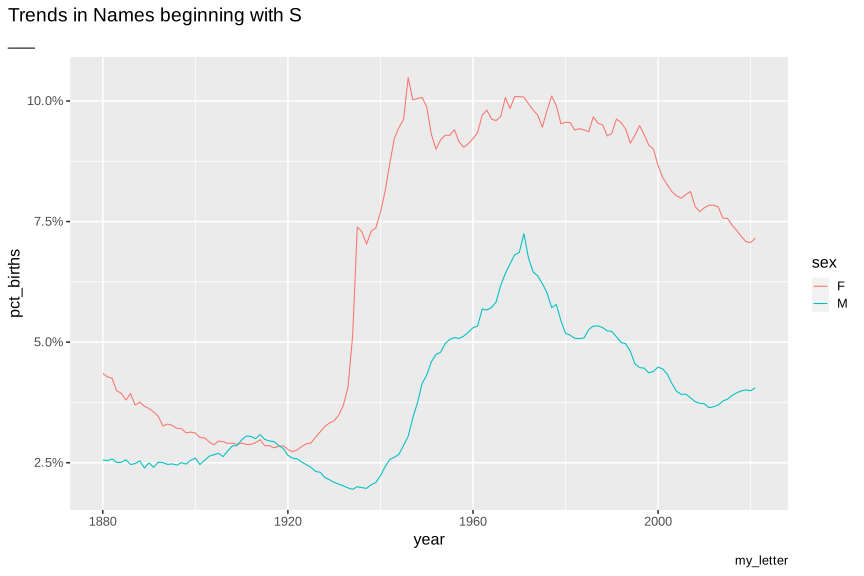

In [17]:
plot_trends_in_letter <- function(my_letter) {
  tbl_names_by_letter |> 
    # Filter for first_letter = my_letter
    filter(first_letter == my_letter) |> 
    # Initialize a ggplot of pct_births vs. year colored by sex
    ggplot(aes(x = year, y = pct_births, color = sex)) +
    # Add a line layer
    geom_line() +
    # Add labels (title, subtitle, caption, x, y)
    labs(
      title = glue::glue("Trends in Names beginning with {my_letter}"),
      subtitle = "___",
      caption = "my_letter",
      x = "year",
      y = 'pct_births'
    ) +
    # Update y-axis scales to display percentages
    scale_y_continuous(labels = scales::percent_format()) +
    # Update theme
    theme(plot.title.position = "plot")
}

plot_trends_in_letter("S")

__Bonus__: How do these plots change when you focus on the `last_letter` instead of the `first_letter`. Feel free to go back and change `first_letter` to  `last_letter` and see what you find. Try to make an educated guess before you run the code, so you can see if your intuition matches up!


### Question 4: [Unveiling Letter Combinations] What secrets do the most popular letter combinations hold?

Are you ready to explore the fascinating realm of letter combinations in names? This question will guide you through the process of analyzing the joint distribution of births by first and last letters. By examining these intriguing patterns, you'll be able to unveil the most popular letter combinations and how they have evolved over the years.

#### Transform

In [22]:
tbl_names_by_first_and_last_letter = tbl_names |> 
  # Filter for sex = "F"
  filter( sex == "F") |>
  # Group by `first_letter`, `last_letter`, and `year`
  group_by(first_letter, last_letter, year) |>
  # Summarize total number of births
  summarize(nb_births = sum(nb_births), .groups = "drop") |>
  
  
  
  # Group by `year`
  group_by(year) |>
  # Add NEW column pct_births by dividing nb_births by sum(nb_births)
mutate(pct_births = nb_births /sum(nb_births)) |>
  # Ungroup data
ungroup()

head(tbl_names_by_first_and_last_letter)

first_letter,last_letter,year,nb_births,pct_births
<chr>,<chr>,<dbl>,<dbl>,<dbl>
A,A,1880,4784,0.05257490
A,A,1881,4966,0.05400585
A,A,1882,5728,0.05311228
A,A,1883,6051,0.05387334
A,A,1884,7038,0.05455011
A,A,1885,7203,0.05413551


#### Visualize

Now, you will visualize the distribution of `pct_births` by `last_letter` and `first_letter` by plotting a heatmap of the percentage of births by first letter and last letter for the year 2021.

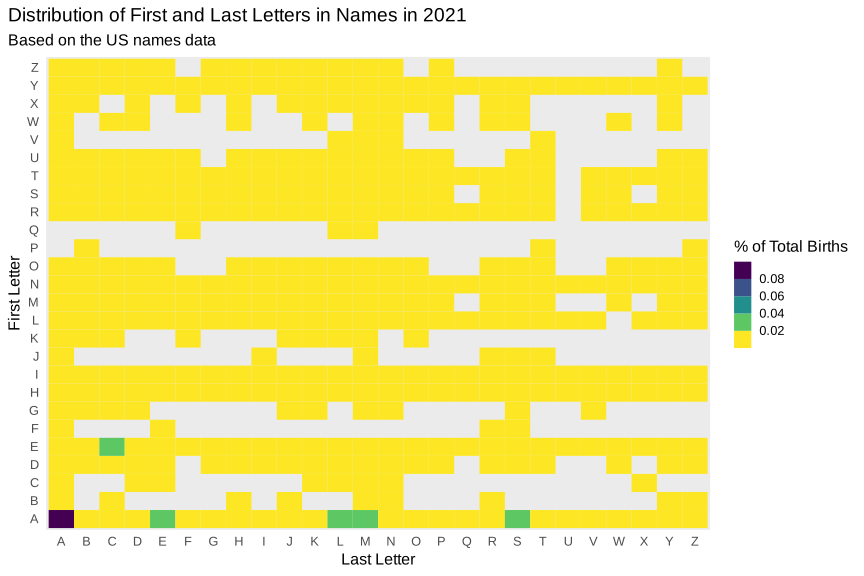

In [24]:
tbl_names_by_first_and_last_letter |> 
  # Filter for the year 2021
  filter( year == 2021) |>
  # Initialize a ggplot of last_letter vs. first_letter
  ggplot(aes(x = first_letter, y = last_letter)) +
  # Add a `geom_tile` layer with fill mapped to pct_births
  geom_tile(aes(fill = pct_births)) +
  # Add labels (title, subtitle, x, y, fill)
 
   labs(title = "Distribution of First and Last Letters in Names in 2021",
       subtitle = "Based on the US names data",
       x = "Last Letter",
       y = "First Letter",
       fill = "% of Total Births") +
  
  



  # Update fill scale to use Viridis colors
  scale_fill_viridis_b(direction = -1) +
  # Update plotting theme
  theme(
    plot.title.position = "plot",
    panel.grid = element_blank(),
    axis.ticks = element_blank()
  )

### Question 5: [Vowels vs Consonants] Are there naming trends in usage of vowels and consonants?

Do certain combinations of vowels and consonants tend to appear more often in names? Are there any notable changes in these patterns over the years? In this question, we'll explore the fascinating world of vowel and consonant usage in names across time. This can help us understand how the structure of names has evolved and what factors may have influenced these changes. By diving into these linguistic aspects, you'll gain a greater appreciation for the intricacies and diversity of names in our dataset. Let's dive in and uncover the trends in the usage of vowels and consonants!

#### Transform

In this step, you will create a function to identify whether a letter is a vowel or a consonant. Then, you will use this function to categorize the first and last letters in names as either vowels or consonants. After that, you will group the data by sex, year, and letter type (vowel or consonant) to calculate the percentage of births for each combination of first and last letter types.

In [32]:
get_letter_type <- function(letter) {
  VOWELS <- c("A", "E", "I", "O", "U")
  ifelse(letter %in% VOWELS, 'vowel', 'consonant')
}

tbl_names_vowel_consonant <- tbl_names |> 
  # Add NEW column named `first_letter_type`
  mutate(first_letter_type = get_letter_type(first_letter)) |>
  # Add NEW column named `last_letter_type`
   mutate(last_letter_type = get_letter_type(last_letter)) |>
  # Group by `sex`, `year`, `first_letter_type` and `last_letter_type`
  group_by(sex, year, first_letter_type, last_letter_type) |>
  # Summarize the total number of births
  summarise(nb_births_total = sum(nb_births), .groups = "drop") |>
  
  
  
  # Group by `sex` and` `year`
  group_by(sex, year) |>
  # Add NEW column with `pct_births` calculated as `nb_births / sum(nb_births)`
   mutate(pct_births= nb_births_total / sum(nb_births_total)) |>
  # Ungroup the data
  ungroup() |>
  # Unite `first_letter_type` and `last_letter_type` into a NEW column named `first_last`
 unite(first_last, first_letter_type, last_letter_type, sep = ",")

head(tbl_names_vowel_consonant)

sex,year,first_last,nb_births_total,pct_births
<chr>,<dbl>,<chr>,<dbl>,<dbl>
F,1880,"consonant,consonant",19988,0.21966283
F,1880,"consonant,vowel",46765,0.51393498
F,1880,"vowel,consonant",5708,0.06272941
F,1880,"vowel,vowel",18533,0.20367277
F,1881,"consonant,consonant",20069,0.21825280
F,1881,"consonant,vowel",47287,0.51425185


#### Visualize

Now, you will create a visualization to display the trends in the usage of vowels and consonants in names over time. The visualization will show the percentage of births by the combination of first and last letter types, separately for each sex.

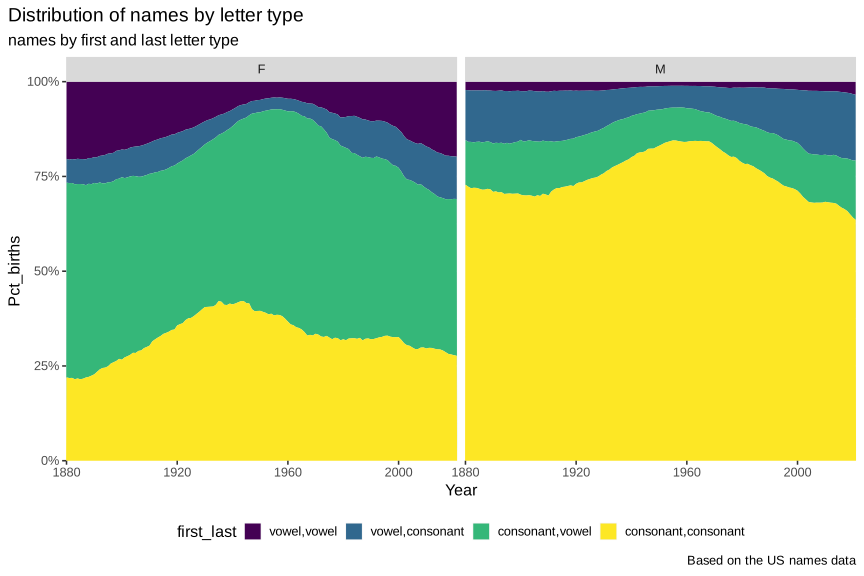

In [34]:
tbl_names_vowel_consonant |> 
  # Reorder `first_last` by the median `pct_births`
  mutate(first_last = fct_reorder(first_last, pct_births, median)) |>
  # Initialize a ggplot of `pct_births` vs. `year`
  ggplot(aes(x = year, y = pct_births)) +
  # Add an area layer with fill = first_last
  geom_area(aes(fill = first_last)) +
  # Facet wrap plot by `sex`
  facet_wrap(~ sex) +
  # Add labels (title, subtitle, caption, x, y)
  
  labs(title = "Distribution of names by letter type",
       subtitle = "names by first and last letter type",
       caption = "Based on the US names data",
       x = "Year",
       y = "Pct_births")+
  
  




  # Clean up x and y axis scales
  scale_x_continuous(
    expand = c(0, 0)
  ) +
  scale_y_continuous(
    expand = c(0, 0),
    labels = scales::percent_format()
  ) +
  # Use Viridis colors for fill
  scale_fill_viridis_d() +
  # Update plotting theme
  theme(
    plot.title.position = 'plot',
    legend.position = 'bottom'
  )

__Note__: The fct_reorder() function is a useful tool for reordering the levels of a factor based on the values of another variable. This function can be particularly helpful when creating visualizations, as it allows you to display data in a more organized and informative manner. In this exercise, fct_reorder() is used to reorder the levels of the first_last factor according to the median of the pct_births variable. By doing so, the resulting plot will show the trends in vowels and consonants usage in a more structured way, making it easier to identify and interpret the patterns.

## MORE BONUS

You can turn your plots into a beautiful dashboard with minimal effort. An Rmarkdown dashboard template has been provided for you. Open the file [project-01-explore-babynames-flexdashboard.Rmd](project-01-explore-babynames-flexdashboard.Rmd). It has placeholders for code, where you can paste the completed code chunks from this document. Pay close attention to the labels of the chunks referred to.